In [1]:
%pip install tensorflow
%pip install numpy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip uninstall torchvision --yes

Found existing installation: torchvision 0.5.0+cu92
Uninstalling torchvision-0.5.0+cu92:
  Successfully uninstalled torchvision-0.5.0+cu92
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL

In [2]:
# load in pretrained VGG-19 on ImageNet
# include_top -> if True it includes flattening and Dense layers that come after convolution and pooling layers
# weights -> "imagenet" value includes weights that VGG-19 had when trained on imagenet
vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")

for layers in vgg.layers:
    layer_info = f"[ {layers.name} ==> {layers.output_shape} ]"
    print(layer_info)

[ input_1 ==> [(None, 224, 224, 3)] ]
[ block1_conv1 ==> (None, 224, 224, 64) ]
[ block1_conv2 ==> (None, 224, 224, 64) ]
[ block1_pool ==> (None, 112, 112, 64) ]
[ block2_conv1 ==> (None, 112, 112, 128) ]
[ block2_conv2 ==> (None, 112, 112, 128) ]
[ block2_pool ==> (None, 56, 56, 128) ]
[ block3_conv1 ==> (None, 56, 56, 256) ]
[ block3_conv2 ==> (None, 56, 56, 256) ]
[ block3_conv3 ==> (None, 56, 56, 256) ]
[ block3_conv4 ==> (None, 56, 56, 256) ]
[ block3_pool ==> (None, 28, 28, 256) ]
[ block4_conv1 ==> (None, 28, 28, 512) ]
[ block4_conv2 ==> (None, 28, 28, 512) ]
[ block4_conv3 ==> (None, 28, 28, 512) ]
[ block4_conv4 ==> (None, 28, 28, 512) ]
[ block4_pool ==> (None, 14, 14, 512) ]
[ block5_conv1 ==> (None, 14, 14, 512) ]
[ block5_conv2 ==> (None, 14, 14, 512) ]
[ block5_conv3 ==> (None, 14, 14, 512) ]
[ block5_conv4 ==> (None, 14, 14, 512) ]
[ block5_pool ==> (None, 7, 7, 512) ]
[ flatten ==> (None, 25088) ]
[ fc1 ==> (None, 4096) ]
[ fc2 ==> (None, 4096) ]
[ predictions ==> (No

In [3]:
from IPython import display

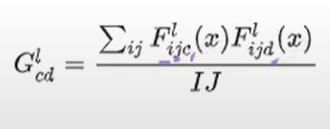

In [4]:
display.Image("./assets/notes/gram_matrix.png")

In [5]:
# Gram Matrix Function

# ex.) block3_pool -> kernel height and width of 28 AND 256 filters
# gram matrix finds correlation between two of these filters
# example -> if a tiger picture is fed in, a filter that detects black stripes and a filter that detects eyes will be STRONGLY correlated
# i -> pixel from a filter
# j -> filter
# c -> a specfic convoluted output
# d -> a different specific convoluted output
# I -> height of the filters in a block
# J -> width of the filters in a block

In [6]:
# Gram Matrix Implementation
# using tf linear algebra library

def gram_matrix(input_tensor):
    # in the formula we are multiplying Fijc by Fijd and expecting Gcd
    # b is for batch
    # input_tensor, input_tensor specifies what c and d should be
    # ex.) multiplying matrix A and B to get matrix C
    # C[i, k] = sum_j A[i, j] * B[j, k]
    # in our case
    # G[c, d] = sum_i sum_j F[i, j, c] * F[i, j, d]
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    # expands the whole thing into batches (because after getting sum you don't have batches anymore)
    gram_matrix = tf.expand_dims(result, axis=0)
    # need to find out i and j
    input_shape = tf.shape(input_tensor)
    # product of I and J (0 index is the batch)
    i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    
    return gram_matrix / i_j
    

In [7]:
# NST Model
def load_vgg():
    # weights shouldn't download every single time model is loaded in BUT im not trynna take up hella space on ur server nikhil so imma just not download the weight files
    vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")
    # we don't want VGG to train because we are optimizing generated image with our loss function
    vgg.trainable = False
    # paper says which layer to work with for content and style exraction
    content_layers = ['block4_conv2']
    # the 1-1 2-1 3-1 4-1 5-1 layers were used in the original paper (conv2d layers directly after each pooling layer up to 29th layer in VGG network)
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    
    content_output = vgg.get_layer(content_layers[0]).output
    style_output = [vgg.get_layer(layer).output for layer in style_layers]
    style_gram_matrix_output = [gram_matrix(out) for out in style_output]
    
    # model takes in two parameters (input, output)
    # in our case the input is [vgg.input] and output is [content_output and style_gram_matrix_output]
    # [vgg.input] -> the input we give to our VGG model
    # [c_o, s_g_m_o] -> the output we get from our model (output from our content layer and gram matrix of all style_layers outputs)
    model = tf.keras.Model([vgg.input], [content_output, style_gram_matrix_output])
    
    return model

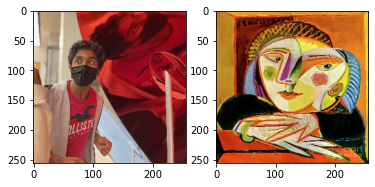

In [8]:
%matplotlib inline

# load in content and style images
content_image = cv2.resize(cv2.imread('./SC_img_pairs/content/venkat.jpg'), (256, 256))
content_image = tf.image.convert_image_dtype(content_image, tf.float32) # puts image pixels into 0-1 instead of 255 (because our VGG model expects a float32 image)
style_image = cv2.resize(cv2.imread('./SC_img_pairs/style/picasso.jpg'), (256, 256))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
# training loop
# adam optimizer - replacing stochastic gd -> better on noisy problems
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

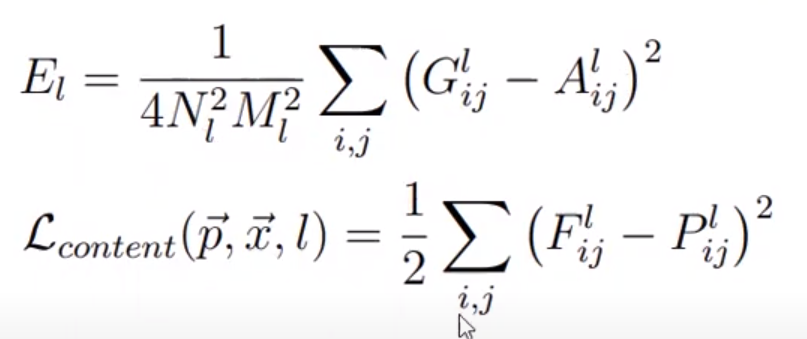

In [10]:
display.Image("./assets/notes/content_style_loss_functions.png")

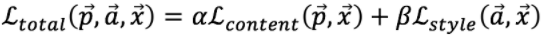

In [11]:
display.Image("./assets/notes/NST_total_loss.png")

In [12]:
# defining loss functions

def content_loss_function(outputs, target):
    # to use a tf function instead of multiplying element-wise differnce by 1/2 we will multiply by 1/mean
    # tf.reduce_mean() does this for us
    # NOTE -> implement content loss function from scratch later
    return tf.reduce_mean((outputs - target) ** 2)

def style_loss_function(outputs, target):
    out_target_pairs = []
    for i in range(len(outputs)):
        out_target_pairs.append((outputs[i], target[i]))
    
    local_losses = []
    for pair in out_target_pairs:
        local_loss = tf.reduce_mean((pair[0] - pair[1]) ** 2)
        local_losses.append(local_loss)
    
    return sum(local_losses)

# TOTAL_LOSS = alpha * content_loss + beta * style_loss
# in original paper
# alpha -> set to -> 1e-4
# beta -> set to -> 1e-2
def loss_function(style_outputs, content_outputs, style_target, content_target):
    alpha = 1e-1
    beta = 1e-1
    
    content_loss = content_loss_function(content_outputs, content_target)
    style_loss = style_loss_function(style_outputs, style_target)
    
    total_loss = (alpha * content_loss) + (beta * style_loss)
    
    return total_loss

In [13]:
vgg_network = load_vgg()
# in the vgg model we defined the model like this -> model = tf.keras.Model([vgg.input], [content_output, style_gram_matrix_output])
# input -> vgg.input
# output -> [content_output, style_gram_matrix_output]
# to get content_ouput we need index 0 in front of vgg_network() call
# to get style_output we need index 1 in front of vgg_network() call
content_target = vgg_network(np.array([content_image*255]))[0]
style_target = vgg_network(np.array([style_image*255]))[1]

In [14]:
# TRAINING FUNCTION

def train_step(image, epoch):
    # we will uses tf's GradientTape which does automatic differentiation
    # auto-diff is basically just calculating gradients for the loss function with respect to whatever inputs
    # gradient is partial deriv of loss/cost function (with respect to a certain variable) -> just like in gd
    # we will then use adam optimizer to optimize the gradients
    with tf.GradientTape() as tape:
        # image input is scaled from 0-1 so we have to multiply by 255 to get it back to normal
        output = vgg_network(image*255)
        style_outputs = output[1]
        content_outputs = output[0]
        # style & content targets already defined in previous cell (they stay constant)
        total_loss = loss_function(style_outputs, content_outputs, style_target, content_target)
    
    # tf.GradientTape() calculates gradients with auto-diff
    gradients = tape.gradient(total_loss, image)
    # using adam optimizer to optimize gradients for convergence
    opt.apply_gradients([(gradients, image)])
    
    # activation in VGG is reLu (rectifier) and we are taking outputs from diff conv layers
    # in the network, some pixel values in the image may go above 255 and multiplying by 255 again when getting outputs will increase gradients by a lot
    # FEATURE SCALING (kind of)
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
    
    if epoch % 25 == 0:
        # just using print() prints out a tensor
        tf.print(f"[ Epoch {epoch} Loss {total_loss}]")

In [16]:
# TRAINING LOOP

EPOCHS = 100
image = tf.image.convert_image_dtype(content_image, tf.float32)
# rn image is just a constant in tensorflow so we have to use tf.Variable to make the image trainable and pixel values can be changed
image = tf.Variable([image])
for i in range(EPOCHS):
    train_step(image, i)

[ Epoch 0 Loss 63985938432.0]
[ Epoch 25 Loss 13141441536.0]
[ Epoch 50 Loss 5707180032.0]
[ Epoch 75 Loss 4159017728.0]


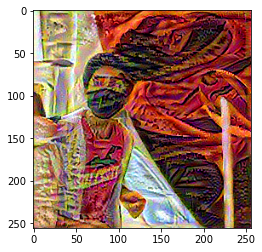

In [17]:
import PIL
import cv2

# CONVERTING TENSOR TO IMAGE -> not my code lmao
tensor = image * 255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]

tensor = PIL.Image.fromarray(tensor)
final_render = cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB)
final_render = PIL.Image.fromarray(final_render)
final_render.save('./render1-venkat-picasso.png')
plt.imshow(final_render)
plt.show()

In [2]:
# IRRELEVANT TORCH IMPLEMENTATION DISREGARD TORCH < TENSORFLOW

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

In [26]:
# import pre-trained VGG-19 model
model = models.vgg19(pretrained=True).features
print(model)

# need to find the 1-1 2-1 3-1 4-1 5-1 conv2d layers
# 1-1 => 0
# 2-1 => 5
# 3-1 => 10
# 4-1 => 19
# 5-1 => 28
conv_layers = ['0', '5', '10', '19', '28'] # these layers used in content loss function

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# inherits from nn.Module
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
    
        self.chosen_features=conv_layers
        self.model = models.vgg19(pretrained=True).features[:int(self.chosen_features[-1])+1] #includes conv layers up to 28
    
    def forward(self, x):
        features = []
        
        for layer_num, layer in enumerate(self.model):
            x = layer(x)